In [229]:
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteOp, FiniteVec, multiply, inner, SiEdSpVec, SpVec, CombVec
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from sklearn.datasets import make_moons

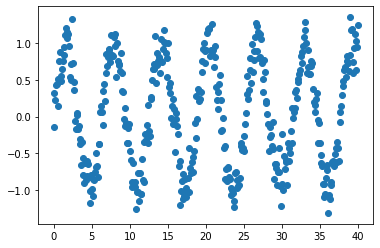

In [230]:
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) + randn(len(x)).reshape((-1, 1)) * 0.2
out_kern = GaussianKernel(0.5)
refervec = FiniteVec(out_kern, np.linspace(y[:-201].min() - 4, y[:-201].max() + 4, 6000)[:, None])

pl.scatter(x.T, y.T)

In [232]:
def plot_pred(mean_var):
    pl.scatter(x.T[:200], y.T[:200].flatten(), color="green")
    pl.scatter(x.T[200:], y.T[200:].flatten(), color="blue")
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)

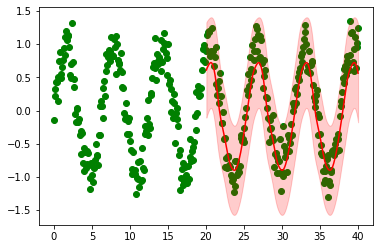

In [233]:
invec = FiniteVec(PeriodicKernel(2*np.pi, 0.3), x[:200])
outvec = FiniteVec(out_kern, y[:200])

cd = Cdo(invec, outvec, refervec)
mean_var = np.array([multiply(cd, FiniteVec(invec.k, x[end-1:end])).normalized().get_mean_var() for end in range(200, 400)])

plot_pred(mean_var)

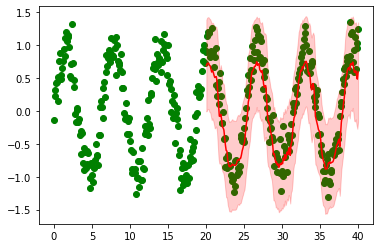

In [234]:
invec = FiniteVec(GaussianKernel(0.5), np.vstack([y[i:i+10].T for i in range(190)]))
outvec = FiniteVec(out_kern, y[10:200])

cd = Cdo(invec, outvec, refervec)
mean_var = np.array([multiply(cd, FiniteVec(invec.k, y[end-10:end].T)).normalized().get_mean_var() for end in range(200, 400)])

plot_pred(mean_var)

In [ ]:
repeated_obs = 4
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) + randn(len(x) * repeated_obs).reshape((-1, repeated_obs)) * 0.2

if False:
    invec = FiniteVec(PeriodicKernel(2*np.pi, 0.3), x.T[0][:200])
    outvec = FiniteVec(out_kern, y[:200].flatten().reshape((-1, 1)), points_per_split = repeated_obs)
else:
    invec = FiniteVec(PeriodicKernel(2*np.pi, 0.3), np.repeat(x.T[0][:200].reshape((-1, 1)), repeated_obs, axis=0))
    outvec = FiniteVec(out_kern, y[:200].flatten().reshape((-1, 1)))

cd = Cdo(invec, outvec, refervec)
mean_var_efficient = np.array([multiply(cd, FiniteVec(invec.k, x[end-1:end])).normalized().get_mean_var() for end in range(200, 400)])

pl.scatter(np.repeat(x.T[0], repeated_obs, axis=0), y.flatten())
pl.plot(mean_var[0])
#y.flatten()